## Day 47 Lecture 1 Assignment

In this assignment, we will apply k-means clustering to a dataset containing player-season statistics for NBA players from the past four years.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

This dataset contains player-season statistics for NBA players from the past four years. Each row in this dataset represents a player's per-game averages for a single season. 

This dataset contains the following variables:

- Seas: season ('2019' = 2018-2019 season, '2018' = 2017-2018 season, etc.)
- Player: player name
- Pos: position
- Age: age
- Tm: team
- G: games played
- GS: games started
- MP: minutes played
- FG: field goals
- FGA: field goals attempted
- FG%: field goal percentage
- 3P: 3 pointers
- 3PA: 3 pointers attempted
- 3P%: 3 point percentage
- 2P: 2 pointers
- 2PA: 2 pointers attempted
- 2P%: 2 point percentage
- eFG%: effective field goal percentage
- FT: free throws
- FTA: free throws attempted
- FT%: free throw percentage
- ORB: offensive rebound
- DRB: defensive rebound
- TRB: total rebounds
- AST: assists
- STL: steals
- BLK: blocks
- TOV: turnovers
- PF: personal fouls
- PTS: points

Load the dataset.

In [2]:
# answer goes here
nba_df = pd.read_csv('data/nba_player_seasons.csv')

nba_df



,Seas,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,2019,Álex Abrines,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2019,Quincy Acy,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,2019,Jaylen Adams,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,2019,Steven Adams,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,2019,Bam Adebayo,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2136,2016,Joe Young,PG,23,IND,41,0,9.4,1.5,4.1,...,0.800,0.1,1.1,1.2,1.6,0.4,0.0,0.8,0.7,3.8
2137,2016,Nick Young,SG,30,LAL,54,2,19.1,2.3,6.9,...,0.829,0.3,1.5,1.8,0.6,0.4,0.1,0.6,0.9,7.3
2138,2016,Thaddeus Young,PF,27,BRK,73,73,33.0,6.8,13.2,...,0.644,2.4,6.6,9.0,1.8,1.5,0.5,1.9,2.5,15.1
2139,2016,Cody Zeller,C,23,CHO,73,60,24.3,3.2,6.0,...,0.754,1.9,4.3,6.2,1.0,0.8,0.9,0.9,2.8,8.7


The goal is to cluster these player-seasons to identify potential player "archetypes".

Begin by removing players whose season did not meet one of the following criteria:
1. Started at least 20 games
2. Averaged at least 10 minutes per game

In [3]:
nba_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2141 entries, 0 to 2140
Data columns (total 30 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Seas    2141 non-null   int64  
 1   Player  2141 non-null   object 
 2   Pos     2141 non-null   object 
 3   Age     2141 non-null   int64  
 4   Tm      2141 non-null   object 
 5   G       2141 non-null   int64  
 6   GS      2141 non-null   int64  
 7   MP      2141 non-null   float64
 8   FG      2141 non-null   float64
 9   FGA     2141 non-null   float64
 10  FG%     2131 non-null   float64
 11  3P      2141 non-null   float64
 12  3PA     2141 non-null   float64
 13  3P%     1967 non-null   float64
 14  2P      2141 non-null   float64
 15  2PA     2141 non-null   float64
 16  2P%     2110 non-null   float64
 17  eFG%    2131 non-null   float64
 18  FT      2141 non-null   float64
 19  FTA     2141 non-null   float64
 20  FT%     2037 non-null   float64
 21  ORB     2141 non-null   float64
 22  

In [4]:
nba_df = nba_df.loc[nba_df['GS'] >= 20]
nba_df = nba_df.loc[nba_df['MP'] >= 10]
nba_df
nba_og = nba_df.copy()



Choose a subset of numeric columns that is interesting to you from an "archetypal" standpoint. 

We will choose the following basic statistics: **points, total rebounds, assists, steals, blocks**, and **turnovers**, but you should feel free to choose other reasonable feature sets if you like. Be careful not to include too many dimensions (curse of dimensionality).

In [5]:
# answer goes here
cols_of_interest = [
    'PTS',
    'TRB',
    'AST',
    'STL',
    'BLK',
    'TOV',
    'MP',
    'FT%',
    '3P',
]

nba_interest = nba_df[cols_of_interest]


Standardize the features in your dataset using scikit-learn's StandardScaler, which will set the mean of each feature to 0 and the variance to 1.

In [6]:
# answer goes here
scaler = StandardScaler()
scaled = scaler.fit_transform(nba_interest)
scaled




array([[ 0.11463777,  1.6129094 , -0.61781554, ...,  0.98199392,
        -2.58644655, -1.3535285 ],
       [-0.7449851 ,  0.76862715, -0.33088552, ..., -0.90364619,
        -0.25522074, -1.3535285 ],
       [ 1.38687962,  1.49778   , -0.23524218, ...,  0.94465452,
         0.85583157, -1.24053537],
       ...,
       [-0.2635963 ,  0.42323896, -0.71345889, ...,  0.14185724,
         0.71695003,  0.79334113],
       [ 0.32094726,  1.42102707, -0.5221722 , ...,  0.90731511,
        -1.15795073, -1.24053537],
       [-0.77937002,  0.34648603, -0.90474557, ..., -0.71694914,
        -0.06673865, -1.3535285 ]])

Run K-means clustering with K = 3 and print out the resulting centroids. When printing the centroids, transform the scaled centroids back into their corresponding unscaled values. What "archetypes" do you see?

In [7]:
k = 3

In [8]:
# answer goes here
k_means = KMeans(n_clusters=k, random_state=42)
k_means.fit(scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

* All Stars
* Defensive
* Other

In [9]:
centroids = scaler.inverse_transform(k_means.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=nba_interest.columns)
centroids_df.style.background_gradient()

,PTS,TRB,AST,STL,BLK,TOV,MP,FT%,3P
0,9.254802,3.893220,1.859887,0.729096,0.391525,1.127119,24.343503,0.760740,1.088701
1,13.220958,8.589820,1.867066,0.793413,1.247904,1.658683,28.398204,0.684940,0.374251
2,18.216961,5.110247,4.787633,1.236042,0.455477,2.385866,32.737102,0.805435,1.820495


In [10]:
pd.crosstab(k_means.labels_, nba_og['Pos']).style.background_gradient()

Pos,C,PF,PF-C,PF-SF,PG,SF,SF-SG,SG
row_0,,,,,,,,
0,39,81,1,2,51,80,1,99
1,118,41,0,0,1,6,0,1
2,9,33,0,0,107,60,1,73


In [11]:
nba_og = nba_og[['PTS', 'TRB', 'BLK', 'AST']]
nba_og['labels'] = k_means.labels_

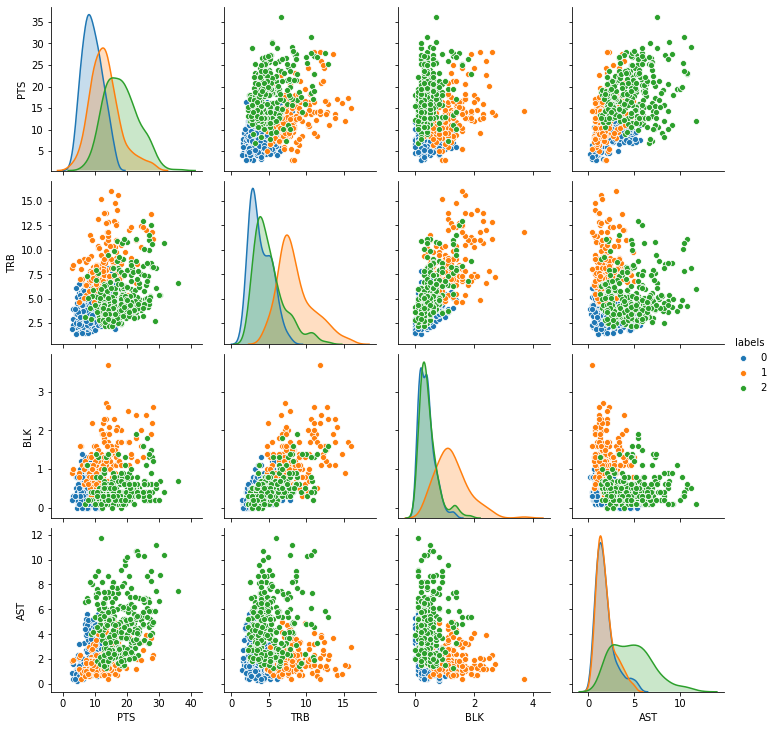

In [12]:
sns.pairplot(nba_og, hue='labels')

Experiment with different values of K. Do any further interesting archetypes come out?

In [13]:
# answer goes here
k = 4
k_means = KMeans(n_clusters=k, random_state=42)
k_means.fit(scaled)

centroids = scaler.inverse_transform(k_means.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=nba_interest.columns)
centroids_df.style.background_gradient()

,PTS,TRB,AST,STL,BLK,TOV,MP,FT%,3P
0,13.150000,4.181667,2.589667,0.931333,0.342000,1.475000,29.455333,0.804527,1.679333
1,14.595652,8.929710,2.036232,0.809420,1.331884,1.773913,29.556522,0.710159,0.457971
2,7.229808,4.347115,1.448077,0.624519,0.514904,1.001923,21.319712,0.702399,0.538942
3,20.104430,5.493038,6.113924,1.388608,0.521519,2.882911,33.384810,0.798519,1.797468


In [14]:
k = 5
k_means = KMeans(n_clusters=k, random_state=42)
k_means.fit(scaled)

centroids = scaler.inverse_transform(k_means.cluster_centers_)
centroids_df = pd.DataFrame(centroids, columns=nba_interest.columns)
centroids_df.style.background_gradient()

,PTS,TRB,AST,STL,BLK,TOV,MP,FT%,3P
0,7.033714,3.706286,1.486286,0.597714,0.424000,0.925143,20.801143,0.731611,0.666857
1,13.398630,4.224315,2.614041,0.929110,0.347260,1.504795,29.689726,0.804476,1.689041
2,19.141176,9.467647,2.861765,0.917647,1.630882,2.241176,32.197059,0.772838,0.872059
3,19.789655,5.187586,6.245517,1.396552,0.452414,2.864828,33.289655,0.802448,1.831034
4,10.686290,7.909677,1.625000,0.803226,0.998387,1.468548,26.602419,0.643371,0.229032


In [15]:

nba_og['labels'] = k_means.labels_

In [16]:
pd.crosstab(nba_og['labels'], nba_og['Pos'])

KeyError: 'Pos'